Imports

In [163]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import padding
import struct
from imblearn.over_sampling import SMOTE
import pennylane as qml
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from web3 import Web3
import json
import tenseal as ts
from hashlib import sha256
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [164]:
ITERATIONS = 15
NUM_CLIENTS = 5
PRIME = 104729  # Prime number for Shamir's Secret Sharing
THRESHOLD = 3 

Hushing functions

In [165]:
# Shamir’s Secret Sharing: Splitting weights
def shamir_split(secret, n, k, prime=PRIME):
    coeffs = [secret] + [random.randint(0, prime - 1) for _ in range(k - 1)]
    shares = [(i, sum(c * (i ** j) for j, c in enumerate(coeffs)) % prime) for i in range(1, n + 1)]
    return shares

# Encrypt weights with CKKS
def encrypt_weights(weights, context):
    encrypted_weights = []
    for weight in weights:
        flat_weights = weight.flatten().tolist()
        encrypted_vector = ts.ckks_vector(context, flat_weights)
        encrypted_weights.append(encrypted_vector)
    return encrypted_weights

# Define Qhash function
def qhash(data):
    """Generate a quantum-resistant hash (SHA-256) for the given data."""
    return sha256(data.encode()).hexdigest()

Aggregation functions

In [166]:
# Generate adaptive factors for each client
def generate_adaptive_factors(num_clients, lower=0.5, upper=1.5):
    """Generate random adaptive factors for clients within a specified range."""
    factors = [random.uniform(lower, upper) for _ in range(num_clients)]
    return factors

# Perform weighted average aggregation
def weighted_average_ckks_nested(encrypted_weights, factors):
    """Perform weighted average aggregation on nested CKKS-encrypted weights."""
    total_factor = sum(factors)
    aggregated_weights = []

    for layer_idx in range(len(encrypted_weights[0])):
        aggregated_layer = encrypted_weights[0][layer_idx].copy()
        for i, client_weights in enumerate(encrypted_weights[1:], start=1):
            aggregated_layer += client_weights[layer_idx] * (factors[i] / total_factor)
            aggregated_weights.append(aggregated_layer)

    # Log size of each layer's aggregated weights
    for idx, layer in enumerate(aggregated_weights):
        print(f"Layer {idx}: Aggregated weights size = {len(layer.decrypt())}")
        return aggregated_weights
    
    
    
# Define Qhash function
def qhash(data):
    """Generate a quantum-resistant hash (SHA-256) for the given data."""
    return sha256(data.encode()).hexdigest()

# Convert the aggregated Qhash to bytes32
def str_to_bytes32(input_str):
    """Convert a string to bytes32."""
    return bytes.fromhex(input_str)

Serialization

In [167]:
def serialize_model_weights(model):
        """Flatten weights and biases for all layers into a single list."""
        serialized_weights = []
        for layer in model.layers:
            if hasattr(layer, "get_weights"):
                weights = layer.get_weights()
                if len(weights) == 2:  # If both weights and biases exist
                    serialized_weights.extend(weights[0].flatten())  # Flatten weights
                    serialized_weights.extend(weights[1].flatten())  # Flatten biases
                elif len(weights) == 1:  # If only weights exist (no biases)
                    serialized_weights.extend(weights[0].flatten())
                else:
                    print(f"Layer {layer.name} has no trainable weights or biases.")
        return [struct.pack("!f", w) for w in serialized_weights]  # Convert to bytes


def encrypt_with_aes(plaintext_weights, key):
    """Encrypt the plaintext weights using AES key."""
    if len(key) not in {16, 24, 32}:
        raise ValueError("Invalid AES key length. Must be 16, 24, or 32 bytes.")

    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    encryptor = cipher.encryptor()

    # Convert list of packed floats to a single byte string
    plaintext_bytes = b"".join(plaintext_weights)

    # PKCS7 padding to align plaintext with AES block size
    padder = padding.PKCS7(128).padder()
    padded_data = padder.update(plaintext_bytes) + padder.finalize()

    # Encrypt in blocks
    encrypted_weights = []
    for i in range(0, len(padded_data), 16):
        block = padded_data[i:i + 16]
        encrypted_weights.append(encryptor.update(block))

    return encrypted_weights

def simulate_qkd_resources(num_nodes):
    """Simulate QKD key generation for secure model redistribution."""
    return {node_id: {"key": os.urandom(16)} for node_id in range(num_nodes)}

Deserialization

In [168]:
def decrypt_with_aes(encrypted_model, key):
    """Decrypt the encrypted global model using the AES key."""
    if len(key) not in {16, 24, 32}:
        raise ValueError("Invalid AES key length. Must be 16, 24, or 32 bytes.")

    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    decryptor = cipher.decryptor()

    # Decrypt all blocks
    decrypted_bytes = b"".join([decryptor.update(block) for block in encrypted_model])

    # Remove PKCS7 padding
    unpadder = padding.PKCS7(128).unpadder()
    plaintext_bytes = unpadder.update(decrypted_bytes) + unpadder.finalize()

    # Unpack floats
    decrypted_weights = [struct.unpack("!f", plaintext_bytes[i:i + 4])[0] for i in range(0, len(plaintext_bytes), 4)]
    return decrypted_weights

def deserialize_model_weights(serialized_weights, model):
    """Reshape serialized weights and biases back to their original shapes."""
    deserialized_weights = []
    start = 0
    for layer in model.layers:
        if hasattr(layer, "get_weights"):
            weights = layer.get_weights()
            if len(weights) == 2:  # Both weights and biases
                weight_shape = weights[0].shape
                bias_shape = weights[1].shape

                weight_count = np.prod(weight_shape)
                bias_count = np.prod(bias_shape)

                weights = np.array(serialized_weights[start:start + weight_count]).reshape(weight_shape)
                biases = np.array(serialized_weights[start + weight_count:start + weight_count + bias_count]).reshape(bias_shape)

                deserialized_weights.append((weights, biases))
                start += weight_count + bias_count
            elif len(weights) == 1:  # Only weights
                weight_shape = weights[0].shape
                weight_count = np.prod(weight_shape)

                weights = np.array(serialized_weights[start:start + weight_count]).reshape(weight_shape)
                deserialized_weights.append((weights, None))
                start += weight_count
    return deserialized_weights

Update Model Function

In [169]:
def update_client_models(client_models, decrypted_global_models):
        """Update client models with the decrypted global weights."""
        for node_id, model in enumerate(client_models):
            if node_id in decrypted_global_models:
                deserialized_weights = deserialize_model_weights(decrypted_global_models[node_id], model)

                # Apply deserialized weights to the model
                for layer, (weights, biases) in zip(model.layers, deserialized_weights):
                    if biases is not None:
                        layer.set_weights([weights, biases])
                    else:
                        layer.set_weights([weights])  # For layers without biases
        print("Client models updated with new global weights.")

Evaluation Function

In [170]:
# Function to evaluate model on the test set
def evaluate_model(global_model, X_test, y_test):
    """
    Evaluate the global model's accuracy on the test dataset.
    """
    y_pred = global_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    accuracy = np.mean(y_pred_classes == y_test) * 100
    return accuracy

Load Dataset

Data pre-proccessing

In [171]:
import numpy as np

def split_data_with_ratio(df, num_clients, target_col='isFraud', ratio=5):
    fraud_indices = df[df[target_col] == 1].index.to_list()
    non_fraud_indices = df[df[target_col] == 0].index.to_list()
    np.random.shuffle(fraud_indices)
    np.random.shuffle(non_fraud_indices)
    
    fraud_per_client = len(fraud_indices) // num_clients
    non_fraud_per_client = int(fraud_per_client * ratio)
    
    client_dfs = []
    for _ in range(num_clients):
        if len(fraud_indices) < fraud_per_client or len(non_fraud_indices) < non_fraud_per_client:
            # Break if there aren't enough samples left
            break
        client_fraud_indices = fraud_indices[:fraud_per_client]
        client_non_fraud_indices = non_fraud_indices[:non_fraud_per_client]
        fraud_indices = fraud_indices[fraud_per_client:]  # Update remaining indices
        non_fraud_indices = non_fraud_indices[non_fraud_per_client:]
        
        client_indices = client_fraud_indices + client_non_fraud_indices
        client_df = df.loc[client_indices]
        client_dfs.append(client_df)
    
    return client_dfs


In [172]:
def split_client_data(client_dfs, test_size=0.2, random_state=42):

    client_splits = []
    
    for client_df in client_dfs:
        # Extract features and target
        X = scaler.fit_transform(client_df.drop(columns=["isFraud"]))
        y = client_df["isFraud"]
        
        # Perform train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # Append the split for this client
        client_splits.append((X_train, X_test, y_train, y_test))
    
    return client_splits

In [173]:
from imblearn.over_sampling import SMOTE
import pandas as pd

from imblearn.over_sampling import SMOTE
import pandas as pd

def balance_with_smote(df, target_col='isFraud', smote_ratio=0.2, random_state=42):
    """Apply SMOTE to increase the minority class size by a specified ratio."""
    X = df.drop(columns=[target_col])
    y = df[target_col]

    smote = SMOTE(sampling_strategy=smote_ratio, random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
    balanced_df[target_col] = y_resampled
    return balanced_df

In [174]:
def count_fraud_percentage(df, fraud_col='isFraud'):
    """
    Calculate the count and percentage of fraud cases in a DataFrame.

    """

    fraud_count = df[fraud_col].sum()

    total_count = len(df)
    fraud_percentage = (fraud_count / total_count) * 100

    return fraud_count, fraud_percentage

In [175]:
finance_df = pd.read_csv("../Downloads/PS_20174392719_1491204439457_log.csv")
finance_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [176]:
# Sort by 'step' to ensure time ordering
finance_df_sorted = finance_df.sort_values(by='step')

# Calculate the interval for sampling evenly across time
interval = len(finance_df_sorted) // 100000

# Sample the dataset
sampled_df = finance_df_sorted.iloc[::interval][:100000]

# Display or save the sampled dataset
sampled_df.reset_index(drop=True, inplace=True)
print(sampled_df)


       step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0         1   PAYMENT    9839.64  C1231006815      170136.00       160296.36   
1         1  CASH_OUT  427823.47   C778806426           0.00            0.00   
2         1  TRANSFER  206336.47   C435803541       89305.99            0.00   
3         1   PAYMENT   10757.70  C1299126654         666.00            0.00   
4         1  TRANSFER   86401.93   C559998250           0.00            0.00   
...     ...       ...        ...          ...            ...             ...   
99995   681   PAYMENT   24281.39  C1130010000       50604.00        26322.61   
99996   681   CASH_IN  239280.42  C1916988135      106821.00       346101.42   
99997   681     DEBIT    6577.58  C1069152629       62044.00        55466.42   
99998   681   PAYMENT   13251.60    C92169307           0.00            0.00   
99999   681  CASH_OUT  173367.70  C1949421870       20511.00            0.00   

          nameDest  oldbalanceDest  new

In [177]:
finance_df=sampled_df
finance_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,CASH_OUT,427823.47,C778806426,0.00,0.00,C2083562754,777546.17,1186556.81,0,0
2,1,TRANSFER,206336.47,C435803541,89305.99,0.00,C812586739,64101.75,122027.28,0,0
3,1,PAYMENT,10757.70,C1299126654,666.00,0.00,M116356643,0.00,0.00,0,0
4,1,TRANSFER,86401.93,C559998250,0.00,0.00,C977993101,879468.12,965870.05,0,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,681,PAYMENT,24281.39,C1130010000,50604.00,26322.61,M128350449,0.00,0.00,0,0
99996,681,CASH_IN,239280.42,C1916988135,106821.00,346101.42,C604722062,0.00,0.00,0,0
99997,681,DEBIT,6577.58,C1069152629,62044.00,55466.42,C1202559316,861444.84,868022.43,0,0
99998,681,PAYMENT,13251.60,C92169307,0.00,0.00,M1976785798,0.00,0.00,0,0


## Cleaning

In [178]:
df_cleaned = finance_df.loc[(finance_df['type'].isin(['CASH_OUT', 'TRANSFER'])),:]

In [179]:
df_cleaned.drop(columns=['nameOrig','nameDest','isFlaggedFraud'],inplace=True)

In [180]:
df_cleaned['type'] = df_cleaned['type'].map({'CASH_OUT': 0, 'TRANSFER': 1})

In [181]:
df_smote_balanced = balance_with_smote(df_cleaned, target_col='isFraud', smote_ratio=0.20, random_state=42)
fraud_count_smote, fraud_percentage_smote = count_fraud_percentage(df_smote_balanced)
print(f"After SMOTE - Fraudulent: {fraud_count_smote}, Fraud Percentage: {fraud_percentage_smote:.2f}%")

After SMOTE - Fraudulent: 8667, Fraud Percentage: 16.67%


In [182]:
final_df=df_smote_balanced

In [183]:
final_df = final_df.sort_values(by='step').astype(float)

In [184]:
final_df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1.0,0.0,427823.47,0.00,0.00,777546.17,1186556.81,0.0
13,1.0,0.0,94296.25,0.00,0.00,336692.95,1178808.14,0.0
12,1.0,0.0,111899.09,12998.94,0.00,10026771.77,16874643.09,0.0
11,1.0,0.0,60758.42,0.00,0.00,155911.68,500631.71,0.0
9,1.0,0.0,64489.64,0.00,0.00,398424.59,16997.22,0.0
...,...,...,...,...,...,...,...,...
43443,681.0,0.0,197728.99,259167.67,61438.68,3502772.06,3700501.05,0.0
43441,681.0,0.0,147041.22,41808.00,0.00,4124216.84,4271258.06,0.0
43442,681.0,0.0,122275.43,0.00,0.00,187214.88,309490.31,0.0
43438,681.0,0.0,155822.66,0.00,0.00,728689.10,884511.76,0.0


In [185]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
final_df[final_df.columns] = scaler.fit_transform(final_df[final_df.columns])
final_df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,0.0,0.0,0.010997,0.000000,0.000000,0.004780,0.006746,0.0
13,0.0,0.0,0.002424,0.000000,0.000000,0.002070,0.006702,0.0
12,0.0,0.0,0.002876,0.000262,0.000000,0.061643,0.095936,0.0
11,0.0,0.0,0.001562,0.000000,0.000000,0.000959,0.002846,0.0
9,0.0,0.0,0.001658,0.000000,0.000000,0.002449,0.000097,0.0
...,...,...,...,...,...,...,...,...
43443,1.0,0.0,0.005083,0.005227,0.001552,0.021534,0.021038,0.0
43441,1.0,0.0,0.003780,0.000843,0.000000,0.025355,0.024283,0.0
43442,1.0,0.0,0.003143,0.000000,0.000000,0.001151,0.001760,0.0
43438,1.0,0.0,0.004005,0.000000,0.000000,0.004480,0.005029,0.0


In [186]:
df=final_df

In [187]:
y = df['isFraud']
X = df.drop(columns=['isFraud'])

In [188]:
X = scaler.fit_transform(X)
# X_reduced =scaler.fit_transform(X_reduced)

In [189]:
# Get the value counts of the target variable
value_counts = y.value_counts()

# Calculate the ratio of 0s to 1s
ratio = value_counts[0] / value_counts[1]

print(f"Value counts:\n{value_counts}")
print(f"Ratio of 0s to 1s: {ratio}")

Value counts:
isFraud
0.0    43335
1.0     8667
Name: count, dtype: int64
Ratio of 0s to 1s: 5.0


In [190]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# X_reduced_train, X_reduced_temp, y_train, y_temp = train_test_split(X_reduced, y, test_size=0.4, random_state=42)
# X_reduced_val, X_reduced_test, y_val, y_test = train_test_split(X_reduced_temp, y_temp, test_size=0.5, random_state=42)

In [191]:
df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,0.0,0.0,0.010997,0.000000,0.000000,0.004780,0.006746,0.0
13,0.0,0.0,0.002424,0.000000,0.000000,0.002070,0.006702,0.0
12,0.0,0.0,0.002876,0.000262,0.000000,0.061643,0.095936,0.0
11,0.0,0.0,0.001562,0.000000,0.000000,0.000959,0.002846,0.0
9,0.0,0.0,0.001658,0.000000,0.000000,0.002449,0.000097,0.0
...,...,...,...,...,...,...,...,...
43443,1.0,0.0,0.005083,0.005227,0.001552,0.021534,0.021038,0.0
43441,1.0,0.0,0.003780,0.000843,0.000000,0.025355,0.024283,0.0
43442,1.0,0.0,0.003143,0.000000,0.000000,0.001151,0.001760,0.0
43438,1.0,0.0,0.004005,0.000000,0.000000,0.004480,0.005029,0.0


In [192]:
client_dfs = split_data_with_ratio(df, NUM_CLIENTS)

In [193]:
client_splits = split_client_data(client_dfs)

In [194]:
client_splits

[(array([[7.52941176e-01, 0.00000000e+00, 3.69185673e-01, ...,
          0.00000000e+00, 1.60783750e-03, 7.17260385e-02],
         [5.75000000e-01, 0.00000000e+00, 3.28159656e-03, ...,
          0.00000000e+00, 2.20602605e-03, 2.82242984e-03],
         [4.82352941e-01, 0.00000000e+00, 1.52453239e-02, ...,
          0.00000000e+00, 3.03351235e-03, 5.91962356e-03],
         ...,
         [3.70588235e-01, 0.00000000e+00, 5.97677995e-03, ...,
          0.00000000e+00, 1.43061189e-03, 2.56145434e-03],
         [6.79411765e-01, 0.00000000e+00, 4.48858986e-03, ...,
          0.00000000e+00, 3.41973082e-04, 1.19367984e-03],
         [2.97058824e-01, 0.00000000e+00, 5.90075337e-03, ...,
          0.00000000e+00, 4.77727799e-03, 5.88282409e-03]]),
  array([[1.95588235e-01, 0.00000000e+00, 6.08949415e-03, ...,
          0.00000000e+00, 4.81417797e-02, 4.91425114e-02],
         [5.29411765e-01, 1.00000000e+00, 1.63366131e-03, ...,
          0.00000000e+00, 1.51480242e-03, 1.82043939e-03],
        

In [195]:
value_counts = client_dfs[2]['isFraud'].value_counts()
print(value_counts)

isFraud
0.0    8665
1.0    1733
Name: count, dtype: int64


Quantum layer Architecture

In [196]:
def custom_layer_long(weights, n_qubits):
    index = 0  # Start index for weights

    # First block of RY
    for i in range(n_qubits + 1):
        qml.RY(weights[index], wires=i)
        index += 1

    # First set of CNOT pairs
    pairs = [(0, 1), (1, 2), (2, 3), (3, 0)]
    for pair in pairs:
        qml.CNOT(wires=pair)

    # Second block of RY
    for i in range(n_qubits + 1):
        qml.RY(weights[index], wires=i)
        index += 1

    # Second set of CNOT pairs
    pairs = [(0, 2), (2, 0)]
    for pair in pairs:
        qml.CNOT(wires=pair)

    # Third block of RY (single qubit repeated)
    qml.RY(weights[index], wires=3)
    index += 1
    qml.RY(weights[index], wires=3)
    index += 1

    # Nested loop of RY
    for j in range(2):
        for i in range(n_qubits):
            qml.RY(weights[index], wires=i)
            index += 1

    # Third set of CNOT pairs
    pairs = [(0, 1), (1, 2), (2, 3), (3, 0)]
    for pair in pairs:
        qml.CNOT(wires=pair)

    # First block of RZ
    for i in range(n_qubits + 1):
        qml.RZ(weights[index], wires=i)
        index += 1

    # Fourth set of CNOT pairs
    pairs = [(0, 2), (2, 0)]
    for pair in pairs:
        qml.CNOT(wires=pair)

    # Fourth block of RY (single qubit repeated)
    qml.RY(weights[index], wires=3)
    index += 1
    qml.RY(weights[index], wires=3)
    index += 1

    # Second block of RZ
    for i in range(n_qubits):
        qml.RZ(weights[index], wires=i)
        index += 1

    # Third block of RY
    for i in range(n_qubits):
        qml.RY(weights[index], wires=i)
        index += 1

    # Fifth set of CNOT pairs
    pairs = [(0, 1), (1, 2), (2, 3), (3, 0)]
    for pair in pairs:
        qml.CNOT(wires=pair)

    # Final block of RZ
    for i in range(n_qubits + 1):
        qml.RZ(weights[index], wires=i)
        index += 1

    return index

Quantum Device and Qnode

In [197]:
# Quantum Device and QNode
n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits + 1)

@qml.qnode(dev)
def qnode_long(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits+1))
    # print("AAAAAAAAAAAAAAAAAAAAA")
    # i=0
    for w in weights:
        # print(i)
        custom_layer_long(w,n_qubits)
        # i+=1
    outputs = [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
    return outputs

n_layers = 1
total_weights_long = 32
weight_shapes_long = {"weights": (n_layers, total_weights_long+1)}

qlayer = qml.qnn.KerasLayer(qnode_long, weight_shapes_long, output_dim=n_qubits)

Local Quantum Model

In [198]:
# Define the local quantum model for each node
def build_quantum_model():
    model = Sequential([
        Dense(4, activation="relu"),
        qlayer,
        Dense(2, activation="softmax")
    ])
    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [199]:
# To store evaluation results
evaluation_results_global = []
evaluation_results_local = []

client_models = [build_quantum_model() for _ in range(NUM_CLIENTS)]


for iteration in range(ITERATIONS):
    print(f"\n--- Iteration {iteration + 1} ---")
    

    for client_id, (X_train, X_test, y_train, y_test) in enumerate(client_splits):
    # for client_id, client_data in enumerate(client_dfs):
        # print(f"Client {client_id} weights: {client_models[client_id].get_weights()}")
        print(f"Training quantum model for Client {client_id + 1}")
        
        # Preprocess client data
        X_client = X_train
        y_client = y_train

        
        # Fit the model with verbose=1 to display training progress
        client_models[client_id].fit(X_client, y_client, batch_size=32, epochs=3, verbose=1)
        # print(f"Trained weights {client_id} weights: {client_models[client_id].get_weights()}")
        

    # Constants for Hybrid Encryption
    PRIME = 104729  # Prime number for Shamir's Secret Sharing
    THRESHOLD = 3  # Threshold for reconstruction in MPC
    NUM_NODES = NUM_CLIENTS  # Each client represents a node

    # Initialize CKKS Context for Homomorphic Encryption
    context = ts.context(
        ts.SCHEME_TYPE.CKKS, poly_modulus_degree=8192, coeff_mod_bit_sizes=[60, 40, 40, 60]
    )
    context.global_scale = 2 ** 40

    print("CKKS Context initialized.")

    

    # Process and secure weights from client models
    # Encrypt weights after training
    encrypted_shares = []
    for client_id, model in enumerate(client_models):
        print(f"Securing weights for Client {client_id + 1}")

        # Extract weights from the trained model
        weights = [layer.get_weights()[0] for layer in model.layers if isinstance(layer, Dense)]

        # Shamir's Secret Sharing (already in place)
        node_shares = []
        for weight_matrix in weights:
            shares = [
                shamir_split(int(value * 1e6), NUM_NODES, THRESHOLD, PRIME)
                for value in weight_matrix.flatten()
            ]
            node_shares.append(shares)

        # CKKS encryption
        encrypted_weights = encrypt_weights(weights, context)

        encrypted_shares.append(encrypted_weights)
        print(f"Client {client_id + 1}: Weights encrypted and secured.")

    # Generate Qhash for encrypted weights
    blockchain_batches = []  # To store batched Qhashes for blockchain

    # Batch size for submission to blockchain
    BATCH_SIZE = 10

    print("Generating Qhashes and preparing batches for the blockchain...")
    # Generate Qhash for encrypted weights


    for batch_start in range(0, len(encrypted_shares), BATCH_SIZE):
        batch_end = min(batch_start + BATCH_SIZE, len(encrypted_shares))
        batch_hashes = []

        for node_id in range(batch_start, batch_end):
            # Flatten and serialize CKKS Vectors for Qhash
            serialized_shares = []
            for encrypted_weight in encrypted_shares[node_id]:
                if isinstance(encrypted_weight, ts.CKKSVector):  # Check for CKKSVector
                    # Convert binary data to hexadecimal
                    serialized_shares.append(encrypted_weight.serialize().hex())
                else:
                    print(f"Skipping non-serializable object of type {type(encrypted_weight)}")

            serialized_shares_str = str(serialized_shares)
            hash_value = qhash(serialized_shares_str)  # Generate Qhash
            batch_hashes.append(hash_value)

        # Store the batch for blockchain submission
        blockchain_batches.append({
            "batch_start": batch_start,
            "batch_end": batch_end,
            "hashes": batch_hashes
        })

    print(f"Prepared {len(blockchain_batches)} batches of Qhashes for blockchain submission.")


    # Connect to Ethereum blockchain
    web3 = Web3(Web3.HTTPProvider("http://127.0.0.1:7545"))  # Update with your provider

    # Load smart contract ABI
    with open('build/contracts/SecureAggregation.json') as f:
        contract_abi = json.load(f)["abi"]

    # Contract address (update with your deployed contract address)
    contract_address = "0xD1171913982F295a2172955E788c73fAD7aFcC06"

    # Initialize smart contract
    contract = web3.eth.contract(address=contract_address, abi=contract_abi)

    # Blockchain account for transactions
    account = web3.eth.accounts[0]
    web3.eth.default_account = account

    # Submit Qhash batches to the blockchain
    print("Submitting Qhash batches to the blockchain...")

    for batch in blockchain_batches:
        try:
            # Convert Qhashes to bytes32 array
            batch_hashes_bytes = [bytes.fromhex(h) for h in batch["hashes"]]
            
            # Submit batch Qhashes to the smart contract
            tx = contract.functions.submitBatch(
                batch["batch_start"], batch["batch_end"], batch_hashes_bytes
            ).transact()
            
            # Wait for transaction receipt
            receipt = web3.eth.wait_for_transaction_receipt(tx)  # Corrected method
            print(f"Batch {batch['batch_start']} to {batch['batch_end']} submitted. Tx Hash: {receipt.transactionHash.hex()}")
        
        except Exception as e:
            print(f"Error submitting batch {batch['batch_start']} to {batch['batch_end']}: {e}")

    print("All Qhash batches successfully submitted to the blockchain.")


    
    # Generate adaptive factors
    adaptive_factors = generate_adaptive_factors(NUM_CLIENTS)

    # Perform aggregation
    print("Aggregating encrypted weights using CKKS and adaptive factors...")
    try:
        aggregated_encrypted_weights = weighted_average_ckks_nested(encrypted_shares, adaptive_factors)
        print("Encrypted weights aggregated successfully.")
    except Exception as e:
        print(f"Error during aggregation: {e}")


    # Generate Qhash for the aggregated weights
    print("Generating Qhash for aggregated encrypted weights...")

    try:
        # Serialize each CKKS-encrypted vector in the aggregated weights
        serialized_aggregated_weights = str([
            weight.serialize().hex() for weight in aggregated_encrypted_weights
            if hasattr(weight, "serialize")  # Ensure the object is serializable
        ])

        # Compute the Qhash
        aggregated_qhash = qhash(serialized_aggregated_weights)
        print(f"Aggregated Encrypted Qhash: {aggregated_qhash}")


        # Store the aggregated Qhash on the blockchain
        print("Storing aggregated Qhash on the blockchain...")
        aggregated_qhash_bytes32 = str_to_bytes32(aggregated_qhash)  # Convert to bytes32
        tx = contract.functions.storeAggregatedQhash(aggregated_qhash_bytes32).transact()
        receipt = web3.eth.wait_for_transaction_receipt(tx)
        print(f"Aggregated Qhash successfully stored on the blockchain. Tx Hash: {receipt.transactionHash.hex()}")
    except Exception as e:
        print(f"Error generating or storing aggregated Qhash: {e}")



    qkd_resources = simulate_qkd_resources(NUM_CLIENTS)
    global_model = client_models[0]  # Example global model
    serialized_weights = serialize_model_weights(global_model)

    # Encrypt serialized weights
    encrypted_global_models = {}
    for node_id, resources in qkd_resources.items():
        key = resources["key"]
        encrypted_global_models[node_id] = encrypt_with_aes(serialized_weights, key)

    print("Global model encrypted for all nodes using AES with QKD keys.")

    

    # Decrypt and update client models
    decrypted_global_models = {}
    for node_id, encrypted_weights in encrypted_global_models.items():
        key = qkd_resources[node_id]["key"]
        decrypted_weights = decrypt_with_aes(encrypted_weights, key)
        decrypted_global_models[node_id] = decrypted_weights

    update_client_models(client_models, decrypted_global_models)

    print("Decrypted weights applied to all client models. Ready for the next iteration.")

    # Evaluate the global model on the test set
    global_model = client_models[0]  # Assuming all models are synced to the same global weights
    
    X_train_0, X_test_0, y_train_0, y_test_0 = client_splits[0]

    global_model=client_models[0]
    
    # Evaluate the global model on combined test set
    X_global_test = np.vstack([X_test for _, X_test, _, _ in client_splits])
    y_global_test = np.hstack([y_test for _, _, _, y_test in client_splits])
    accuracy_global = evaluate_model(global_model, X_global_test, y_global_test)

    # Evaluate the first client's model on its own test set
    accuracy_local_1 = evaluate_model(client_models[0], X_test_0, y_test_0)

    print(f"Iteration {iteration + 1}: Global model accuracy on combined test set = {accuracy_global:.2f}%")
    print(f"Iteration {iteration + 1}: Client 1 model accuracy on its own test set = {accuracy_local_1:.2f}%")

    evaluation_results_global.append(accuracy_global)
    evaluation_results_local.append(accuracy_local_1)
    
    
    
    
    # accuracy = evaluate_model(global_model, X_test_0, y_test_0)
    
    # accuracy_local_1=evaluate_model(client_models[0], X, y)
    
    
    # print(f"Iteration {iteration + 1}: Global model accuracy = {accuracy:.2f}%")
    # print(f"accuracy local  = {accuracy_local_1:.2f}%")
    # evaluation_results.append(accuracy)





--- Iteration 1 ---
Training quantum model for Client 1
Epoch 1/3
260/260 [==============================] - 68s 263ms/step - loss: 0.3921 - accuracy: 0.8364
Epoch 2/3
260/260 [==============================] - 67s 257ms/step - loss: 0.2970 - accuracy: 0.8849
Epoch 3/3
260/260 [==============================] - 67s 258ms/step - loss: 0.2518 - accuracy: 0.9014
Training quantum model for Client 2
Epoch 1/3
260/260 [==============================] - 68s 260ms/step - loss: 0.4106 - accuracy: 0.8281
Epoch 2/3
260/260 [==============================] - 68s 261ms/step - loss: 0.3151 - accuracy: 0.8795
Epoch 3/3
260/260 [==============================] - 68s 261ms/step - loss: 0.2824 - accuracy: 0.8904
Training quantum model for Client 3
Epoch 1/3
260/260 [==============================] - 68s 260ms/step - loss: 0.3695 - accuracy: 0.8536
Epoch 2/3
260/260 [==============================] - 69s 264ms/step - loss: 0.2960 - accuracy: 0.8825
Epoch 3/3
260/260 [==============================] - 68

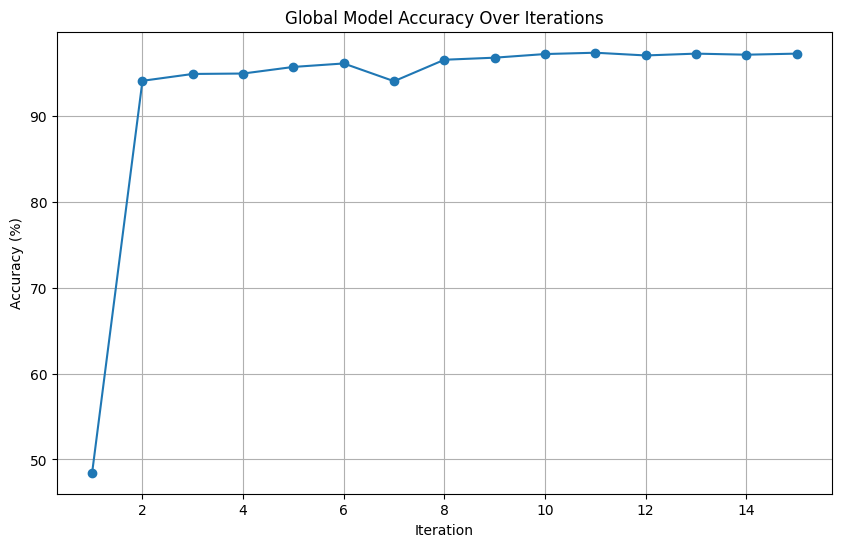

In [200]:
# Plot evaluation results
plt.figure(figsize=(10, 6))
plt.plot(range(1, ITERATIONS + 1), evaluation_results_global, marker='o')
plt.title('Global Model Accuracy Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.show()

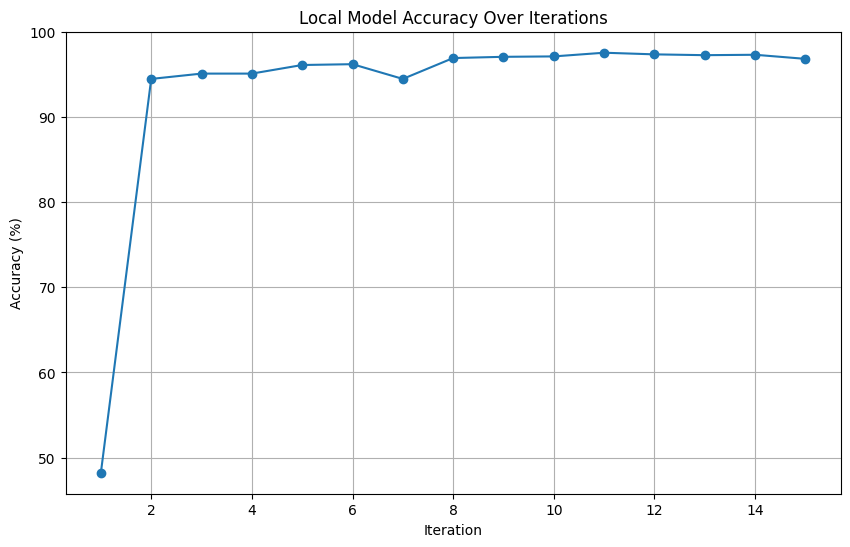

In [201]:
# Plot evaluation results
plt.figure(figsize=(10, 6))
plt.plot(range(1, ITERATIONS + 1), evaluation_results_local, marker='o')
plt.title('Local Model Accuracy Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.show()

In [202]:
for i in range(len(client_splits)):
    X_train, X_test, y_train, y_test = client_splits[i]
    accuracy_local = evaluate_model(client_models[i], X_test, y_test)
    print(f"Client {i}: Accuracy = {accuracy_local}")


65/65 [==============================] - 6s 96ms/step
Client 0: Accuracy = 96.82692307692308
65/65 [==============================] - 6s 97ms/step
Client 1: Accuracy = 97.45192307692308
65/65 [==============================] - 6s 95ms/step
Client 2: Accuracy = 97.5
65/65 [==============================] - 6s 97ms/step
Client 3: Accuracy = 97.3076923076923
65/65 [==============================] - 6s 96ms/step
Client 4: Accuracy = 97.11538461538461
